*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module04_01_overfitting_basis_function_regression.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [11]:
%autosave 0
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Autosave disabled


# Nonlinear modeling using basis function regresssion

A linear function is not sufficient for fitting data that does not follow a linear relationship:

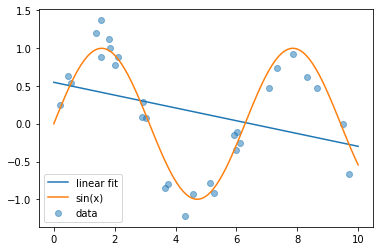

In [42]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# create data
rng = np.random.RandomState(42)
N = 30
x = 10 * rng.rand(N)
y = np.sin(x) + 0.2 * rng.randn(N)

xfit = np.linspace(0, 10, 100)

lr.fit(x[:, np.newaxis], y)
yfit = lr.predict(xfit[:, np.newaxis])

plt.scatter(x, y, alpha=0.5, label='data')
plt.plot(xfit, yfit, label='linear fit');
plt.plot(xfit, np.sin(xfit), label = 'sin(x)')
plt.legend();

There are two ways to address this issue:

* Use a non-linear classifier
* Transform the features using a non-linear function.

We will explore the latter approach.

First, consider data with a single feature $x$.  Instead of using $x$ as-is, let us first transform it using a collection of nonlinear functions.  As an example, replace $x$ with all monomials of degree up to $D$:
$$
(x^0, x^1, x^2, x^3, \ldots ,x^D).
$$

We will use a linear model using these features:

$$
f(x) = w_0 + w_1 x + w_2 x^2 + \ldots, + w_D x^D.
$$

The model is still linear in the parameters, even though the function it computes is nonlinear.  Therefore our machinery for computing the solution still works without any need for modification - all we need to do is transform our features.

In [44]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([[2],[3]])
poly = PolynomialFeatures(3, include_bias=True)
poly.fit_transform(X)

array([[ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.]])

Let's apply this idea and see how well it works:

In [35]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(6),
                           LinearRegression())

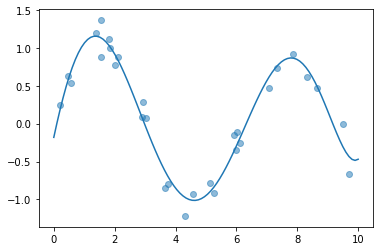

In [36]:
rng = np.random.RandomState(42)
N = 30
x = 10 * rng.rand(N)
y = np.sin(x) + 0.2 * rng.randn(N)

xfit = np.linspace(0, 10, 100)
poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y, alpha=0.5)
plt.plot(xfit, yfit);

The code we used above used a new scikit-learn concept - **pipelines**.
In many cases we need to apply several steps of *preprocessing* to our data before applying the *fit* function.  These steps need to be applied to both training and test data.  To simplify the process we can express these steps as a pipeline that encapsulates the series of steps, and performs them all automatically on the input data.  These steps can include many types of feature manipulation and processing:

* Standardization
* Selection of relevant features
* Compute nonlinear features

Pipelines make the preprocessing steps as part of the classifier.
Pipelines will support the process of selecting parameters of the classification process (e.g. degree of nonlinear features or the number of features that are to be used).  This will allow treating these parameters as hyperparameters of your classification pipeline.

### Exercise

Explore the above code as a function of the degree of the polynomial.
What are you observing?

### Nonlinear features for higher dimensional data

So far we explored nonlinear features in one dimension.  Let's explore the idea for higher dimensional data.
In one dimension we mapped our data to the set of monomials of up to degree $D$:

$$
(1, x^1, x^2, x^3, \ldots ,x^D).
$$

To generalize this to a $d$ dimensional feature vector $\mathbf{x}$, we consider all monomials with degree up to $D$.  For example, for two dimensional data $\mathbf{x} = (x_1, x_2)$ and $D=2$ the resulting set of features is

$$
(1, x_1, x_2, x_1^2, x_2^2, x_1 x_2)
$$

and our regression function takes on the form:

$$
f(\mathbf{x}) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1^2 + w_4 x_2^2 + w_5 x_1 x_2
$$

And in scikit-learn:

In [45]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([[2, 3], [3, 4]])

poly = PolynomialFeatures(2, include_bias=True)
# include bias determines if to include the case where all feature 
# powers are zero; this serves as a bias term 
poly.fit_transform(X)

array([[ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  3.,  4.,  9., 12., 16.]])

### Questions

* Write out the set of monomials up to degree $3$ for two dimensional data

* Assuming your data is in $d$ dimensions, what is the dimensionality of the resulting features when using monomials of degree up to 2?  What does that tell us about the feasibility of this approach for high dimensional data?

The approach described above is regression using **polynomial basis functions**.  More generally we can express this approach as creating a transformation of the data using a set of functions known as *basis functions*:

$$
\Phi(\mathbf{x}) = (\phi_1(\mathbf{x}),\ldots,\phi_D(\mathbf{x}))
$$

Another common approach is to use Gaussian rather than polynomial functions as your basis functions.


### Overfitting

While mapping our data to a higher dimensional feature space is very useful for being able to model data that exhibit non-linear relationships, that increased flexibility can lead to dangerous consequences as the next figure demonstrates:

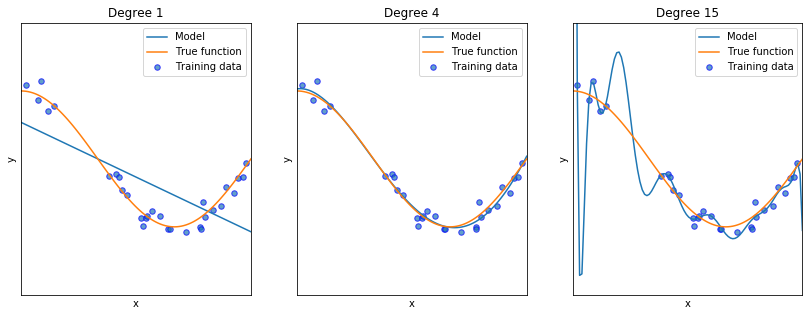

In [46]:
# code based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    Xs = np.linspace(0, 1, 100)
    plt.plot(Xs, pipeline.predict(Xs[:, np.newaxis]), label="Model")
    plt.plot(Xs, true_fun(Xs), label="True function")
    plt.scatter(X, y, edgecolor='b', s=30, alpha=0.7,label="Training data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}".format(degrees[i]))


We observe that with increased feature-space dimensionality the resulting regression function has increased flexibility.  There is a sweet-spot that provides optimal performance, and once we go past that, our regression function, although it fits the data quite well, begins to behave erratically.  It has become too flexible and exhibits a phenomenon known as **overfitting**.  A model that is overfitting is not likely to generalize well to unseen data.  It is too focused on fitting the data, which is not a good idea:  real-world data contains noise, and what we are interested in is learning the underlying patterns, rather than specifics of a particular training set.

### Overfitting

In summary, a model that is overfitting has the following characteristics:

- It matches the training set too closely.
- It does well on the training data, but doesn't *generalize* to new data.
- It learns from the noise in the data, rather than the signal.

Linear regression is a relatively simple model that does not tend to overfit even if you include irrelevant features.
Overfitting may occur when the number of features becomes comparable to the number of training examples.